In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy import stats
from vnstock import *

In [4]:
us = pd.read_csv("us_stock.csv", index_col="Date", parse_dates=True)
vn = pd.read_csv("vn_price.csv", index_col="TradingDate", parse_dates=True)

# Mã cổ phiếu

In [5]:
vn.columns

Index(['AAA', 'AAM', 'AAT', 'ABR', 'ABS', 'ABT', 'ACB', 'ACC', 'ACG', 'ACL',
       ...
       'VPS', 'VRC', 'VRE', 'VSC', 'VSH', 'VSI', 'VTB', 'VTO', 'YBM', 'YEG'],
      dtype='object', length=406)

# Mô phỏng $S(t)=S(0)e^{\sigma B_t+(\mu-\frac12 \sigma^2)t}$

## Lý thuyết

$t\in [0,1]$

$\mu = 0.5$

$\sigma = 0.02$

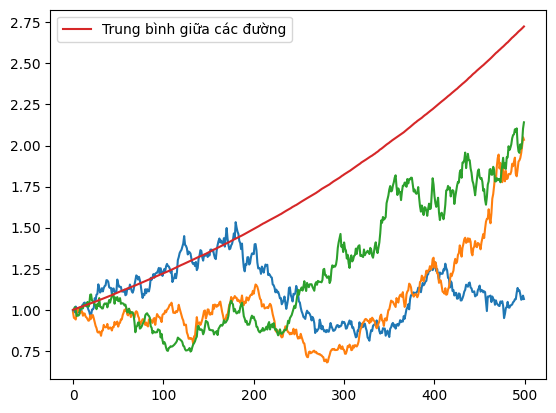

In [6]:
T=1
N=500 # Số bước 
M=10000 # Số kịch bản
dt=T/N
t=np.arange(0,1,dt)
dW = np.sqrt(dt)*np.random.randn(M,N)
W = np.cumsum(dW,axis=1)
mu=1
sigma=0.5
U=np.exp((mu-0.5*sigma**2)*t+sigma*W)
Umean = np.mean(U,axis=0)
plt.plot(U[:3].T) #Vẽ 5 đường
plt.plot(Umean,label="Trung bình giữa các đường")
plt.legend()
plt.show()

## Thực hành

### Ước lượng $\mu$ và $\sigma$

Giả sử mô hình chuyển động của giá là $S(t)=S(0)e^{\sigma B_t+(\mu-\frac12 \sigma^2)t}$
#### Ước lượng $\mu$
$$
\begin{aligned}
&\Rarr r=\frac{dS_t}{S_t}=\mu dt+\sigma dB_t\\
&\Rarr E(r)=E(\frac{dS_t}{S_t})=E(\mu dt+\sigma dB_t)\\
&\Rarr E(r)=E(\mu dt)+E(\sigma dB_t)\\
&\Rarr E(r)=\mu E(dt)\\
&\Rarr \frac{E(r)}{dt}=\mu
\end{aligned}
$$

#### Ước lượng $\sigma$
$$
\begin{aligned}
&\Rarr r=\frac{dS_t}{S_t}=\mu dt+\sigma dB_t\\
&\Rarr V(r)=V(\frac{dS_t}{S_t})=V(\mu dt+\sigma dB_t)\\
&\Rarr V(r)=V(\mu dt)+V(\sigma dB_t)\\
&\Rarr V(r)=\sigma^2 \times dt\\
&\Rarr \sqrt{\frac{V(r)}{dt}}=\sigma
\end{aligned}
$$

#### Hàm tính toán $\mu$ và $\sigma$ dựa vào dữ liệu đầu vào là Giá và dt

In [16]:
def mu_sigma(df,dt):
    mu = (df.pct_change().mean())/dt
    sigma = np.sqrt(df.pct_change().var()/dt)
    return mu, sigma

In [17]:
ticker = "VIC"
start = "2013-01-01"
end = "2023-01-31"
vn_df = vn[ticker][(pd.Timestamp(start).date()<=vn.index.date)&(vn.index.date<=pd.Timestamp(end).date())]

### Mô phỏng

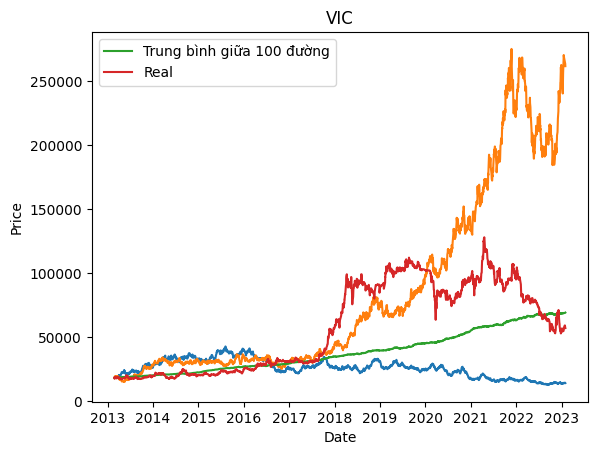

1.5333974657085312
0.886716349021218


In [22]:
T=1
N=len(vn_df) # Số bước 
M=100 # Số kịch bản
dt=T/N
t=np.arange(0,1,dt)
dW = np.sqrt(dt)*np.random.randn(M,N)
W = np.cumsum(dW,axis=1)

mu, sigma = mu_sigma(vn_df,dt)

S0=vn_df.iloc[0,]
U=np.exp((mu-0.5*sigma**2)*t+sigma*W)

Umean = np.mean(U,axis=0)

plt.plot(vn_df.index,S0*U[:2].T) #Vẽ 3 đường
plt.plot(vn_df.index,S0*Umean,label=f"Trung bình giữa {M} đường")
plt.plot(vn_df,label="Real")
plt.title(f"{ticker}")
plt.ylabel("Price")
plt.xlabel("Date")
plt.legend()
plt.show()
print(mu)
print(sigma)

In [10]:
def draw_vn(ticker):
    vn_df = vn[ticker].dropna()
    T=1
    N=len(vn_df) # Số bước 
    M=10000 # Số kịch bản
    dt=T/N
    t=np.arange(0,1,dt)
    dW = np.sqrt(dt)*np.random.randn(M,N)
    W = np.cumsum(dW,axis=1)

    mu, sigma = mu_sigma(vn_df,dt)

    S0=vn_df.iloc[0,]
    U=np.exp((mu-0.5*sigma**2)*t+sigma*W)

    Umean = np.mean(U,axis=0)

    plt.plot(vn_df.index,S0*U[5:7].T) #Vẽ 3 đường
    plt.plot(vn_df.index,S0*Umean,label=f"Trung bình giữa {M} đường")
    plt.plot(vn_df,label="Real")
    plt.title(f"{ticker}")
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend()
    plt.show()
    print(mu)
    print(sigma)

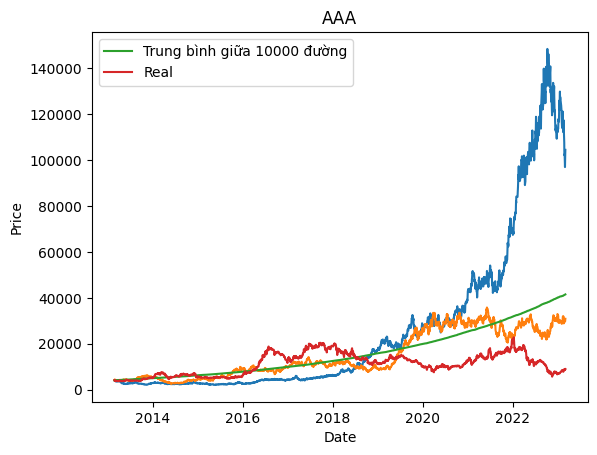

2.316211057524917
1.2364405657614057


In [11]:
draw_vn("AAA")

In [12]:
res = []
for i in vn.columns:
    vn_df = vn[i].dropna()
    T=1
    N=len(vn_df) # Số bước 
    M=10000 # Số kịch bản
    dt=T/N
    mu, sigma = mu_sigma(vn_df,dt)    
    res.append([mu,sigma])


In [13]:
df = pd.DataFrame(res,columns=["mu","sigma"],index=vn.columns)
df["mu/sigma"]=df["mu"]/df["sigma"]

In [14]:
df.sort_values(by="mu/sigma",ascending=False)

,mu,sigma,mu/sigma
FIR,2.617035,0.511727,5.114123
GAB,3.037826,0.649179,4.679487
DHC,4.554698,1.086705,4.191292
TV2,5.392635,1.317606,4.092753
THG,4.832621,1.186703,4.072310
...,...,...,...
ACG,-0.450567,0.362960,-1.241366
NO1,-0.145934,0.116550,-1.252110
GMH,-0.610013,0.479583,-1.271967
SVD,-1.015111,0.695400,-1.459750


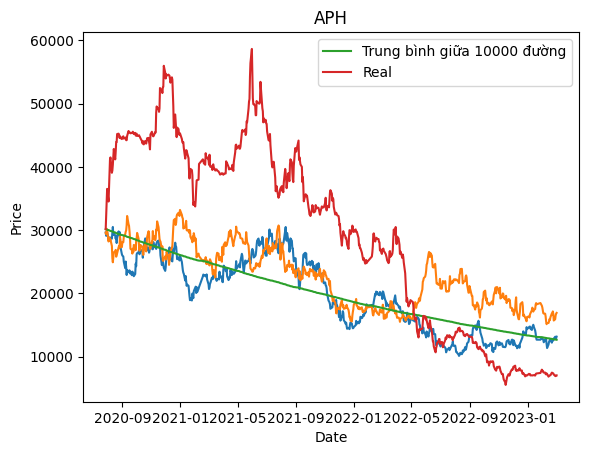

-0.8754226241131945
0.7595155884644984


In [15]:
draw_vn("APH")